<a href="https://colab.research.google.com/github/sid2610/HPE_Goal/blob/main/HPE_GoalDetction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import imageio
import skimage
import cv2
import random
import matplotlib.pyplot as plt
import pickle

TensorFlow 1.x selected.


In [2]:
from skimage import color
from scipy.ndimage.filters import convolve
from skimage.color import rgb2gray
from skimage.transform import resize

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten

In [4]:
def sobel_edges(img):
    img = rgb2gray(img)
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    return np.hypot(Ix, Iy)

In [5]:
def penalty_area(frame):
    frame_1 = np.zeros(frame.shape)
    frame_1 = frame.astype(np.float)/255
    for y in range(frame.shape[0]):
        for x in range(frame.shape[1]):
            if (frame[y][x][1]<(np.max([frame[y][x][0],frame[y][x][2]]))):
                frame_1[y][x] *= 0
    frame_2 = color.rgb2gray(frame_1)
    v = 0
    for i in range(frame_2.shape[0]):
        if (np.sum(frame_2[i])/frame_2.shape[1])>0.2:
            v = i
            break
    frame_3 = frame_2[v:]
    e = sobel_edges(frame_3)
    e_1 = (e>0.1) * 0.5
    uy = 10
    while np.sum(e_1[uy:uy+5,900:1000])/100<1.5:
        uy += 1
    ux = 750
    while np.sum(e_1[uy:uy+5,ux:ux+5])!=0:
        ux += 10
    ux -= 10
    while np.sum(e_1[uy:uy+5,ux])!=0:
        ux += 1
    ugy = uy + 10
    while np.sum(e_1[ugy:ugy+5,ux-100:ux])/100<1.5:
        ugy += 1
    ugx = ux
    while np.sum(e_1[ugy:ugy+5,ugx])!=0:
        ugx += 10
    ugx -= 10
    while np.sum(e_1[ugy:ugy+5,ugx])!=0:
        ugx += 1
    upy = ugy + 10
    while np.sum(e_1[upy:upy+5,ugx-50:ugx])/50<1.5:
        upy += 1
    upx = ugx
    while np.sum(e_1[upy:upy+5,upx])!=0:
        upx -= 10
    upx += 10
    while np.sum(e_1[upy:upy+5,upx])!=0:
        upx -= 1
    lpy = upy + 10
    while np.sum(e_1[lpy:lpy+5,upx+50:upx+100])/50<1.5:
        lpy += 1
    lpx = upx+100
    while np.sum(e_1[lpy:ugy+5,lpx])!=0:
        lpx += 10
    lpx -= 10
    while np.sum(e_1[lpy:lpy+5,lpx])!=0:
        lpx += 1
    return upx, upy, lpx, lpy

In [6]:
def extract_frame(frame, x, y, h, w):
    hh = int(h/2)
    ww = int(w/2)
    if x>=ww and x<(frame.shape[1]-ww):
        lx = ww
    elif x<ww:
        lx = x
    else:
        lx = w-(frame.shape[1]-x)
    if y>=hh and y<(frame.shape[0]-hh):
        ly = hh
    elif y<hh:
        ly = y
    else:
        ly = h-(frame.shape[0]-y)
    return frame[y-ly:y+h-ly, x-lx:x+w-lx]

In [7]:
def sliding_window(img, win, step):
    for y in range(0,img.shape[0]-win[1],step):
        for x in range(0,img.shape[1]-win[0],step):
            yield (x,y,img[y:y+win[1],x:x+win[0]])

In [8]:
model_cnn_adam = Sequential()

model_cnn_adam.add(Conv2D(16, (3,3), (1,1), 'same', activation='relu', input_shape = (100,100,1)))
model_cnn_adam.add(BatchNormalization(-1))
model_cnn_adam.add(MaxPooling2D((2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Conv2D(32, (3,3), (1,1), 'same', activation='relu'))
model_cnn_adam.add(BatchNormalization(-1))
model_cnn_adam.add(MaxPooling2D((2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Conv2D(64, (3,3), (1,1), 'same', activation='relu'))
model_cnn_adam.add(BatchNormalization(-1))
model_cnn_adam.add(MaxPooling2D((2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Conv2D(128, (3,3), (1,1), 'same', activation='relu'))
model_cnn_adam.add(BatchNormalization(-1))
model_cnn_adam.add(MaxPooling2D((2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Flatten(input_shape = (6,6,128)))
model_cnn_adam.add(Dense(1024, activation='relu'))
model_cnn_adam.add(Dense(64, activation='relu'))
model_cnn_adam.add(Dense(1, activation='sigmoid'))

model_cnn_adam.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
model_cnn_adam.load_weights('./ball_adam.h5')

In [10]:
vid = imageio.get_reader('./fifa_1.mp4')

In [11]:
win = (100,100)
step = 10

In [13]:
result = []
for j in range(0, vid.get_length()):
    print(j)
    frame = vid.get_data(j)
    if (j%5==0):
        (ux,uy,lx,ly) = penalty_area(frame)
    locs = []
    preds = []
    test = frame[uy:ly, ux:lx]
    test_bw = rgb2gray(test)
    test_bw = np.expand_dims(test_bw, -1)
    for x,y,roi in sliding_window(test_bw, win, step):
        if x==0 and y%10==0:
            print(x,y)
        locs.append((x,y))
        t = np.expand_dims(roi, 0)
        preds.append(model_cnn_adam.predict(t))
    clone = test.copy()
    p = 0
    if np.max(preds)>0.99:
        for k in preds:
            if k==np.max(preds):
                p += 1
                if p>1:
                    break
    for k in range(len(preds)):
        if np.max(preds) > 0.99:
            i = np.argmax(preds)
            cv2.rectangle(clone, (locs[i][0],locs[i][1]), (locs[i][0]+100,locs[i][1]+100), (0,0,255), 2)
    result.append(clone)

0
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
0 200
1
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
0 200
2
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
0 200
3
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
4
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
5
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
6
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
7
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0 170
0 180
0 190
8
0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
0 100
0 110
0 120
0 130
0 140
0 150
0 160
0

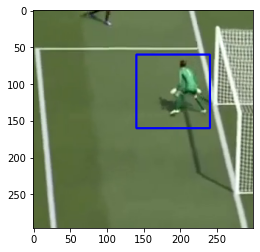

In [15]:
plt.imshow(result[20])

In [16]:
for i in range(len(result)):
    result[i] = resize(result[i], (300,300))

In [18]:
imageio.mimwrite('./result_1.mp4', result, fps=10)